In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage import metrics

import matplotlib.transforms as transforms
from math import pi

In [2]:
path = os.path.abspath("..")

X_val = np.load(path+"/train_test_data/X_val.npy")
y_val = np.load (path+"/train_test_data/y_val.npy")

X_val.shape, y_val.shape

((137, 17, 64, 64, 3), (137, 17, 64, 64, 1))

In [3]:
model = load_model(path+"/lstm_model_2.h5")
history = np.load(path+"/history_2.npy", allow_pickle=True).item()

In [4]:
def scale_array(arr):
    arr_min = np.min(arr)  ## Flattens the array and finds the min value inside it
    arr_max = np.max(arr)  ## Flattens the array and finds the max value inside it
    scaled_array = (arr - arr_min) / (arr_max - arr_min) * 255
    scaled_array = scaled_array.astype(np.uint8)
    
    return scaled_array

In [5]:
GT_array = y_val
a, b, c, d, e = y_val.shape[0], y_val.shape[1], y_val.shape[2], y_val.shape[3], y_val.shape[4] 
PD_array = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_val.shape[0]):
    frames = X_val[i]   ## taking 1 validation video sample at one time
    PD_array[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

GT_scaled = scale_array(y_val)
PD_scaled = scale_array(PD_array)

GT_array.shape, PD_array.shape

((137, 17, 64, 64, 1), (137, 17, 64, 64, 1))

In [6]:
X_g1 = np.delete(np.concatenate((X_val, PD_array), axis=-1), 0, axis=-1)
X_g1 = np.delete(X_g1, -1, axis=1)
y_g1 = np.delete(y_val, 0, axis=1)

a, b, c, d, e = y_g1.shape[0], y_g1.shape[1], y_g1.shape[2], y_g1.shape[3], y_g1.shape[4] 
PD_G1 = np.zeros((a, b, c, d, e))   ## Predicted arrays
for i in range(X_g1.shape[0]):
    frames = X_g1[i]   ## taking 1 validation video sample at one time
    PD_G1[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g1_scaled = scale_array(y_g1)
PD_G1_scaled = scale_array(PD_G1)

y_g1.shape, PD_G1.shape

((137, 16, 64, 64, 1), (137, 16, 64, 64, 1))

In [7]:
X_g2 = np.delete(np.concatenate((X_g1, PD_G1), axis=-1), 0, axis=-1)
X_g2 = np.delete(X_g2, -1, axis=1)
y_g2 = np.delete(y_g1, 0, axis=1)

a, b, c, d, e = y_g2.shape[0], y_g2.shape[1], y_g2.shape[2], y_g2.shape[3], y_g2.shape[4] 
PD_G2 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g1.shape[0]):
    frames = X_g2[i]   ## taking 1 validation video sample at one time
    PD_G2[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g2_scaled = scale_array(y_g2)
PD_G2_scaled = scale_array(PD_G2)

y_g2.shape, PD_G2.shape

((137, 15, 64, 64, 1), (137, 15, 64, 64, 1))

In [8]:
X_g3 = np.delete(np.concatenate((X_g2, PD_G2), axis=-1), 0, axis=-1)
X_g3 = np.delete(X_g3, -1, axis=1)
y_g3 = np.delete(y_g2, 0, axis=1)

a, b, c, d, e = y_g3.shape[0], y_g3.shape[1], y_g3.shape[2], y_g3.shape[3], y_g3.shape[4] 
PD_G3 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g2.shape[0]):
    frames = X_g3[i]   ## taking 1 validation video sample at one time
    PD_G3[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g3_scaled = scale_array(y_g3)
PD_G3_scaled = scale_array(PD_G3)

y_g3.shape, PD_G3.shape

((137, 14, 64, 64, 1), (137, 14, 64, 64, 1))

In [9]:
from scipy import ndimage as ndi
from skimage.feature import shape_index
from skimage.draw import disk

import matplotlib.patheffects as path_effects


[1] https://www.sciencedirect.com/science/article/abs/pii/026288569290076F?via%3Dihub

[2] https://journals.aps.org/prb/abstract/10.1103/PhysRevB.78.024113

The shape index is a single valued measure of local curvature of image microstructure and it is mathematically obtained from the eigen values of the Hessian [1], defined by Koenderink & van Doorn

The blue and magenta marks are points which deviate no more than 0.5 from the desired shape. 
To attenuate noise in the signal, the magenta marks are taken from the shape index (s) after another Gaussian blur pass (yielding s’).

Gaussian Smoothing sigma = 0.5


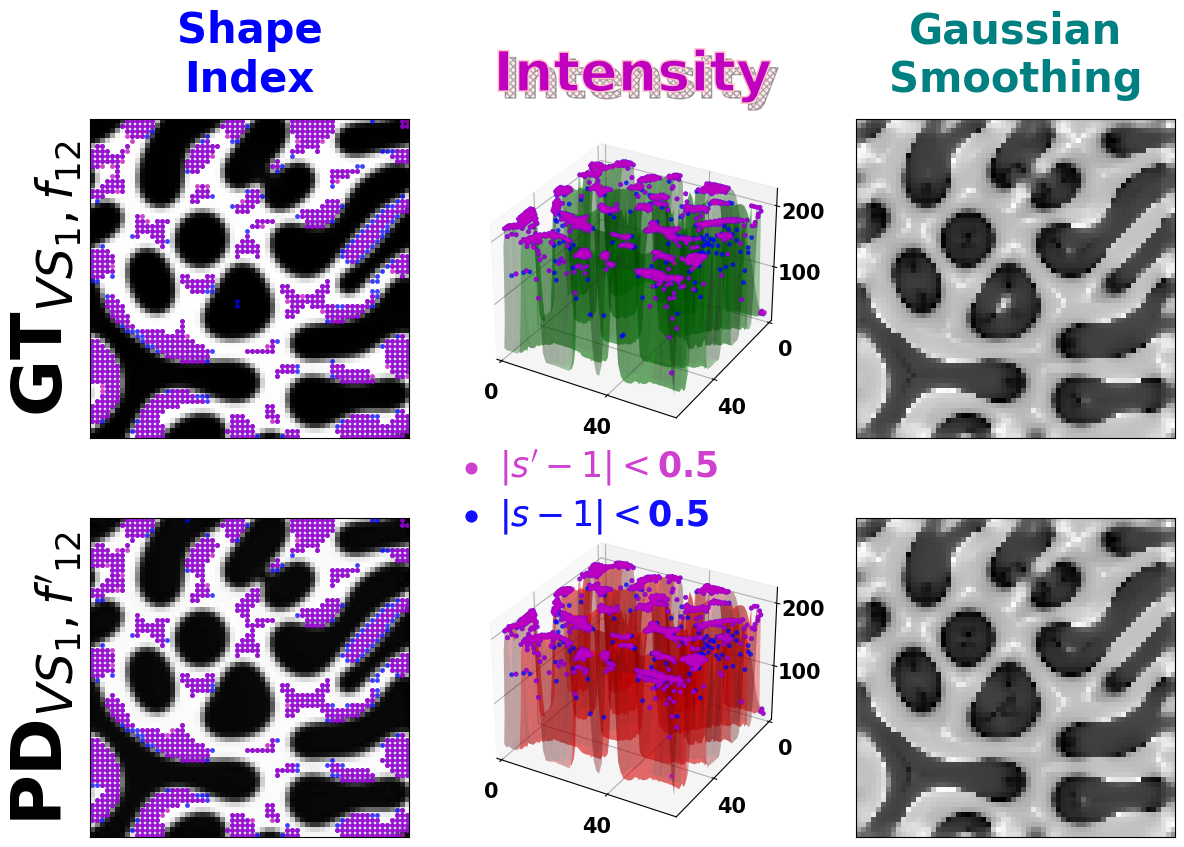

In [102]:

vs = 1
f = 12

VS_F = r"$_{VS_%s, f_{%s}}$"%(vs,f)
VS_F_P = r"$_{VS_%s, f'_{%s}}$"%(vs,f)

pd_img = PD_scaled[vs,f,:,:,0]
gt_img = GT_scaled[vs,f,:,:,0]

s = shape_index(gt_img)

target = 1
delta = 0.5

point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = gt_img[point_y, point_x]
s_smooth = ndi.gaussian_filter(s, sigma=0.5)
point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = gt_img[point_y_s, point_x_s]


fig = plt.figure(figsize=(14, 9.5))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


ax1 = fig.add_subplot(2, 3, 1)

ax1.imshow(gt_img, cmap=plt.cm.gray)
ax1.set_title('Shape\nIndex', color="Blue", fontsize=30, weight='bold', pad=20)
ax1.set_ylabel('GT'+VS_F, fontsize=50, weight='bold')
scatter_settings = dict(alpha=0.75, s=12, linewidths=0)
ax1.scatter(point_x, point_y, color='blue', **scatter_settings)
ax1.scatter(point_x_s, point_y_s, color='m', **scatter_settings)

ax2 = fig.add_subplot(2, 3, 2, projection='3d', sharex=ax1, sharey=ax1)
x, y = np.meshgrid(np.arange(0, gt_img.shape[0], 1), np.arange(0, gt_img.shape[1], 1))
ax2.plot_surface(x, y, gt_img, linewidth=0, alpha=0.35, color="green")
sp2_0 = ax2.scatter(point_x, point_y, point_z, color='blue', label=r'$|s - 1|<$%s'%delta, **scatter_settings)
sp2_1 =ax2.scatter(point_x_s, point_y_s, point_z_s, color='m', label='$|s\' - 1|<$%s'%delta, **scatter_settings)

# legend2_1 = ax2.legend(loc=2, prop={'weight':'bold', 'size':'15'}, markerscale=3, handlelength=0, handles=[sp2_0], labels=[r'$|s - 1|<$%s'%delta],  labelcolor='linecolor', frameon=False)
legend2_2 = ax2.legend(loc=(-0.05,-0.2),  prop={'weight':'bold', 'size':'25'}, markerscale=2.5, handlelength=0, handles=[sp2_1], labels=['$|s\' - 1|<$%s'%delta],  labelcolor='linecolor', frameon=False)
# ax2.add_artist(legend2_1)

# ax2.axis('off')
ax2.set_title('Intensity', color='m', fontsize=40, weight='bold', pad=20).set_path_effects([ path_effects.PathPatchEffect(offset=(5, -5), hatch='xxxxx', facecolor='pink', alpha=0.3), path_effects.PathPatchEffect(edgecolor='pink', linewidth=1.1, facecolor='m')])

ax3 = fig.add_subplot(2, 3, 3, sharex=ax1, sharey=ax1)
ax3.imshow(s, cmap=plt.cm.gray)
# ax3.axis('off')
ax3.set_title('Gaussian\nSmoothing', color='teal', fontsize=30, weight='bold', pad=20)
# .set_title(r'Shape index, $\sigma=1$')

#############################################################

s = shape_index(pd_img)


point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = pd_img[point_y, point_x]


s_smooth = ndi.gaussian_filter(s, sigma=0.5)

point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = pd_img[point_y_s, point_x_s]

ax4 = fig.add_subplot(2, 3, 4)

ax4.imshow(pd_img, cmap=plt.cm.gray)
ax4.set_ylabel('PD'+VS_F_P, fontsize=50, weight='bold')
scatter_settings = dict(alpha=0.75, s=12, linewidths=0)
ax4.scatter(point_x, point_y, color='blue', **scatter_settings)
ax4.scatter(point_x_s, point_y_s, color='m', **scatter_settings)

ax5 = fig.add_subplot(2, 3, 5, projection='3d', sharex=ax1, sharey=ax1)
x, y = np.meshgrid(np.arange(0, pd_img.shape[0], 1), np.arange(0, pd_img.shape[1], 1))
ax5.plot_surface(x, y, pd_img, linewidth=0, alpha=0.35, color="red")
sp5_0 = ax5.scatter(point_x, point_y, point_z, color='blue', label=r'$|s - 1|<$%s'%delta, **scatter_settings)
sp5_1 = ax5.scatter(point_x_s, point_y_s, point_z_s, color='m', label='$|s\' - 1|<$%s'%delta, **scatter_settings)

legend5_1 = ax5.legend(loc=(-0.05,0.90), prop={'weight':'bold', 'size':'25'}, markerscale=2.5, handlelength=0, handles=[sp5_0], labels=[r'$|s - 1|<$%s'%delta],  labelcolor='linecolor', frameon=False)
# legend5_2 = ax5.legend(loc=(0,0.95), prop={'weight':'bold', 'size':'15'}, markerscale=3, handlelength=0, handles=[sp5_1], labels=['$|s\' - 1|<$%s'%delta],  labelcolor='linecolor', frameon=False)
ax5.add_artist(legend5_1)

ax6 = fig.add_subplot(2, 3, 6, sharex=ax1, sharey=ax1)
ax6.imshow(s, cmap=plt.cm.gray,)


ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.zaxis.set_major_locator(plt.MaxNLocator(2))
ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
ax5.yaxis.set_major_locator(plt.MaxNLocator(2))
ax5.zaxis.set_major_locator(plt.MaxNLocator(2))


for label in ax2.get_xticklabels(): label.set_fontweight('bold')
for label in ax2.get_yticklabels(): label.set_fontweight('bold')
for label in ax2.get_zticklabels(): label.set_fontweight('bold')
for label in ax5.get_xticklabels(): label.set_fontweight('bold')
for label in ax5.get_yticklabels(): label.set_fontweight('bold')
for label in ax5.get_zticklabels(): label.set_fontweight('bold') 

ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax2.tick_params(axis='both', labelcolor='black', labelsize=15, bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=True)
ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax5.tick_params(axis='both', labelcolor='black', labelsize=15, bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=True)
ax6.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# fig.tight_layout()
plt.savefig('figures/Shape_Index.png', transparent=True)
plt.savefig("/home/upadesh/1 Research Project/PhD/0 My Research Papers/0 ConvLSTM/manuscript/figures/Shape_Index.png", transparent=True)  ## For Manuscript
plt.show()